In [9]:
# Imports neccesary to work on the project
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import random

In [10]:
# We begin the process of unifying the images in their corresponding category.
cat_train_images = glob.glob('./PetImages/Cat/*.jpg')
dog_train_images = glob.glob('./PetImages/Dog/*.jpg')

cat_test_images = glob.glob('./PetImages/Cat/*.jpg')
dog_test_images = glob.glob('./PetImages/Dog/*.jpg')

In [11]:
print(f"Number of CAT images: {len(cat_train_images)}")
print(f"Number of DOG images: {len(dog_train_images)}")

Number of CAT images: 12498
Number of DOG images: 12498


In [12]:
# Labels are assigned to the images, e.g. 0 for CAT and 1 for DOG.
cat_train_labels = [0] * len(cat_train_images)
dog_train_labels = [1] * len(dog_train_images)

cat_test_labels = [0] * len(cat_test_images)
dog_test_labels = [1] * len(dog_test_images)

In [13]:
# The images and labels from the CAT and DOG folders are now combined into a single dataset.
train_images = cat_train_images + dog_train_images
train_labels = cat_train_labels + dog_train_labels

test_images = cat_test_images + dog_test_images
test_labels = cat_test_labels + dog_test_labels

In [14]:
# The data set is shuffled to ensure a good distribution of the images.
train_indices = np.arange(len(train_images))
np.random.shuffle(train_indices)
train_images = [train_images[i] for i in train_indices]
train_labels = [train_labels[i] for i in train_indices]

test_indices = np.arange(len(test_images))
np.random.shuffle(test_indices)
test_images = [test_images[i] for i in test_indices]
test_labels = [test_labels[i] for i in test_indices]

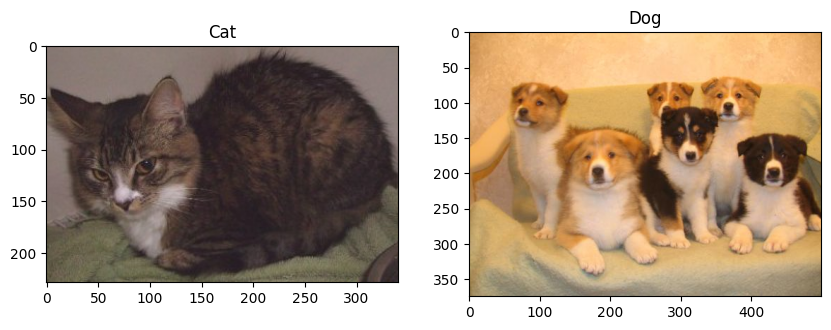

In [15]:
# Both cases are shown in order to observe the differences clearly
train_cat = './PetImages/Cat/'
train_dog = './PetImages/Dog/'

# Cat pic
rand_cat = np.random.randint(0, len(os.listdir(train_cat)))
cat_pic = os.listdir(train_cat)[rand_cat]
cat_pic_address = train_cat + cat_pic

# Dog pic
rand_dog = np.random.randint(0, len(os.listdir(train_dog)))
dog_pic = os.listdir(train_dog)[rand_dog]
dog_address = train_dog + dog_pic

# Load the images and convert to grayscale
cat_load = Image.open(cat_pic_address)
dog_load = Image.open(dog_address)

# Plot the images
f = plt.figure(figsize=(10, 6))
a1 = f.add_subplot(1, 2, 1)
img_plot = plt.imshow(cat_load)
a1.set_title('Cat')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(dog_load)
a2.set_title('Dog')

plt.show()

In [16]:
# Data is loaded and formatted to make sure it fits the CNN
def random_rotation_angle():
    return random.randint(0, 360)

def load_images(path, label):
    images = []
    labels = []
    for img_path in glob.glob(path + '/*.jpg'):
        img = Image.open(img_path).resize((150, 150))
        rotation_angle = random_rotation_angle()
        rotated_img = img.rotate(rotation_angle)
        img_array = np.array(rotated_img) / 255.0
        images.append(img_array)
        labels.append(label)
    return images, labels

train_cat = './PetImages/Cat/'
train_dog = './PetImages/Dog/'

cat_images, cat_labels = load_images(train_cat, 0)
dog_images, dog_labels = load_images(train_dog, 1)

images = cat_images + dog_images
labels = cat_labels + dog_labels

images = np.array(images)
labels = np.array(labels)
images = images.reshape(-1, 150, 150, 1)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)